In [10]:
import pandas as pd
import numpy as np
data = pd.read_csv("df_text_eng.csv")
data.head()

,Unnamed: 0,blurb,state
0,1,"Using their own character, users go on educati...",failed
1,2,"MicroFly is a quadcopter packed with WiFi, 6 s...",successful
2,3,"A small indie press, run as a collective for a...",failed
3,4,Zylor is a new baby cosplayer! Back this kicks...,failed
4,5,Hatoful Boyfriend meet Skeletons! A comedy Dat...,failed


In [13]:
del data['Unnamed: 0'] 
from io import StringIO
data['state_id'] = data['state'].factorize()[0]
state_id_df = data[['state', 'state_id']].drop_duplicates().sort_values('state_id')
state_to_id = dict(state_id_df.values)
id_to_state = dict(state_id_df[['state_id', 'state']].values)
data.head()

,blurb,state,state_id
0,"Using their own character, users go on educati...",failed,0
1,"MicroFly is a quadcopter packed with WiFi, 6 s...",successful,1
2,"A small indie press, run as a collective for a...",failed,0
3,Zylor is a new baby cosplayer! Back this kicks...,failed,0
4,Hatoful Boyfriend meet Skeletons! A comedy Dat...,failed,0


<function matplotlib.pyplot.show(*args, **kw)>

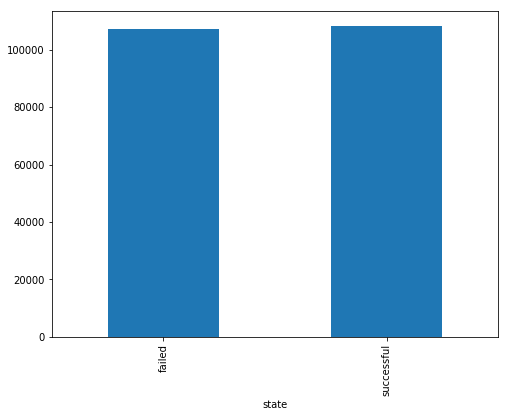

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
data.groupby('state').blurb.count().plot.bar(ylim=0)
plt.show

In [15]:
import re
def clean(text):
    text = str(text)
    text = re.findall(r'\w+', text)
    return ' '.join(text)
data['blurb'] = data['blurb'].apply(lambda x: clean(x))

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
x_train, x_test, y_train, y_test = train_test_split(data['blurb'], data['state'], train_size=0.7, random_state=42)
vectorizer = TfidfVectorizer().fit(x_train)
x_train_v = vectorizer.transform(x_train)
x_test_v  = vectorizer.transform(x_test)

In [17]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from time import time
entries = []
def train():
    models = {
        "LogisticRegression": LogisticRegression(),
        "SGDClassifier": SGDClassifier(),
        "Multinomial":MultinomialNB(),
        "LinearSVC": LinearSVC(),
    }
    for model in models:
        print("training model"+model)
        start = time()
        models[model].fit(x_train_v, y_train)
        end = time()
        print("trained in {} secs".format(end-start))
        y_pred = models[model].predict(x_test_v)
        entries.append((model,accuracy_score(y_test, y_pred)))

In [18]:
train()

training modelLogisticRegression


D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


trained in 2.763514995574951 secs
training modelSGDClassifier
trained in 0.4574165344238281 secs
training modelMultinomial
trained in 0.35732531547546387 secs
training modelLinearSVC
trained in 2.827583074569702 secs


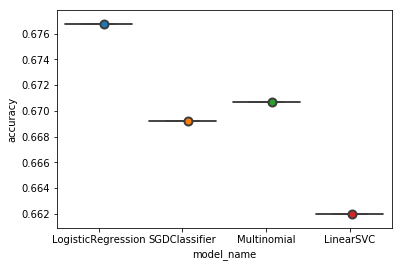

In [19]:
cv_df = pd.DataFrame(entries, columns=['model_name','accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


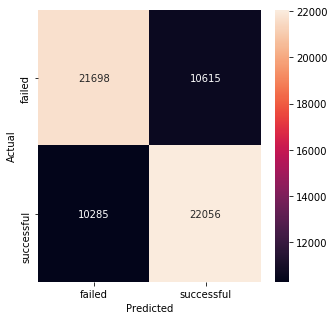

In [20]:
model = LogisticRegression()
model.fit(x_train_v, y_train)
y_pred = model.predict(x_test_v)
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=state_id_df.state.values, yticklabels=state_id_df.state.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      failed       0.68      0.67      0.67     32313
  successful       0.68      0.68      0.68     32341

    accuracy                           0.68     64654
   macro avg       0.68      0.68      0.68     64654
weighted avg       0.68      0.68      0.68     64654



In [22]:
import pickle

In [23]:
filename = 'NLP_model.sav'
pickle.dump(model, open(filename, 'wb'))